In [1]:
!pip install tensorflow tensorflow opencv-python matplotlib


[notice] A new release of pip is available: 23.1.2 -> 23.2.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import tensorflow as tf
import os
import flask

In [3]:
#Remove corrupted images
import cv2
import imghdr
from matplotlib import pyplot as plt

In [4]:
data_dir = 'data' 

In [5]:
os.listdir(data_dir)

['fake logo', 'real logo']

In [6]:
image_exts = ['jpeg','jpg', 'bmp', 'png']

In [7]:
for image_class in os.listdir(data_dir): 
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try: 
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts: 
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e: 
            print('Issue with image {}'.format(image_path))

In [8]:
#Load Data
import numpy as np

In [9]:
data = tf.keras.utils.image_dataset_from_directory('data')

Found 560 files belonging to 2 classes.


In [10]:
data_iterator = data.as_numpy_iterator()

In [11]:
batch = data_iterator.next()

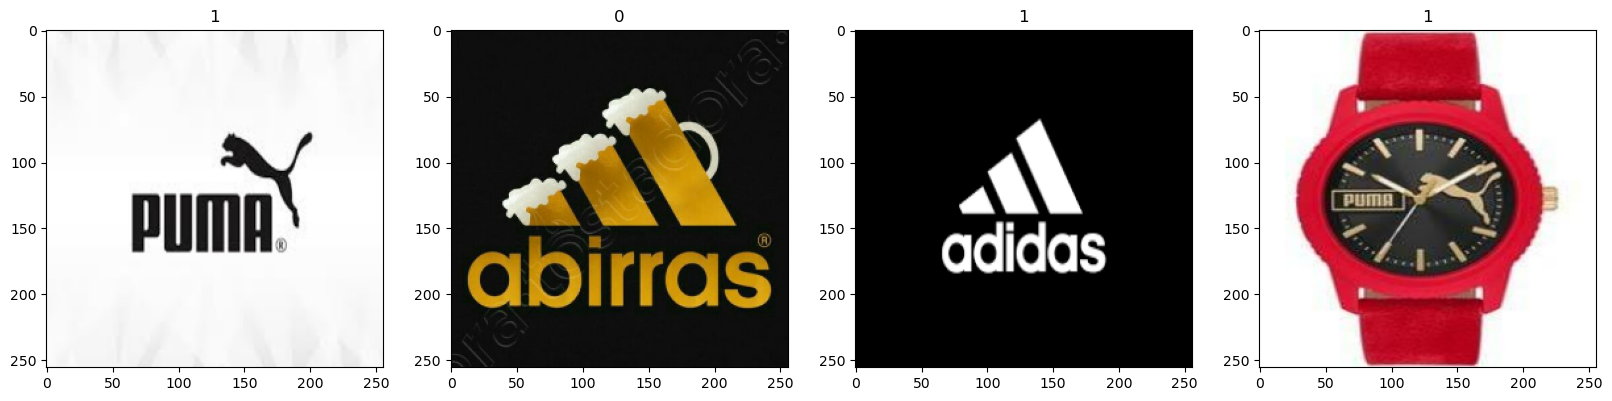

In [12]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

In [13]:
#Scale Data
data = data.map(lambda x,y: (x/255, y))

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [14]:
scaled_iterator = data.as_numpy_iterator()

In [15]:
batch = scaled_iterator.next()

In [16]:
data.as_numpy_iterator().next()

(array([[[[0.99607843, 0.        , 0.        ],
          [0.99607843, 0.        , 0.        ],
          [0.99607843, 0.        , 0.        ],
          ...,
          [0.99607843, 0.        , 0.        ],
          [0.99607843, 0.        , 0.        ],
          [0.99607843, 0.        , 0.        ]],
 
         [[0.99607843, 0.        , 0.        ],
          [0.99607843, 0.        , 0.        ],
          [0.99607843, 0.        , 0.        ],
          ...,
          [0.99607843, 0.        , 0.        ],
          [0.99607843, 0.        , 0.        ],
          [0.99607843, 0.        , 0.        ]],
 
         [[0.99607843, 0.        , 0.        ],
          [0.99607843, 0.        , 0.        ],
          [0.99607843, 0.        , 0.        ],
          ...,
          [0.99607843, 0.        , 0.        ],
          [0.99607843, 0.        , 0.        ],
          [0.99607843, 0.        , 0.        ]],
 
         ...,
 
         [[0.99607843, 0.        , 0.        ],
          [0.99607

In [17]:
batch[0].max()

1.0

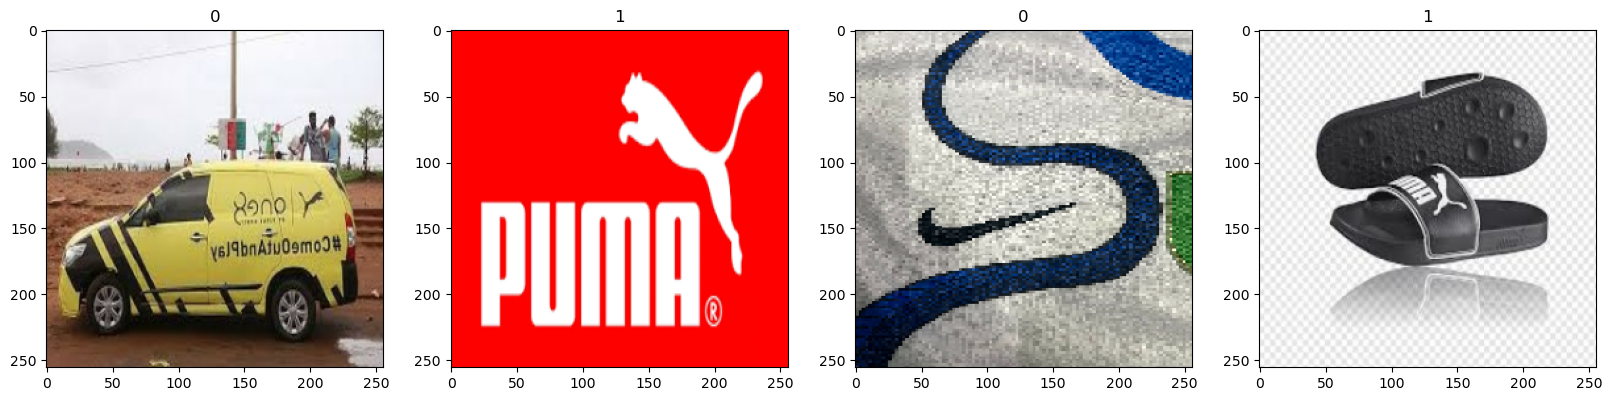

In [18]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img)
    ax[idx].title.set_text(batch[1][idx])

In [19]:
len(data)

18

In [20]:
#Split data
train_size = int(len(data)*.7)
val_size = int(len(data)*.2)
test_size = int(len(data)*.1)

In [21]:
train_size

12

In [22]:
val_size

3

In [23]:
test_size

1

In [24]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

In [25]:
#Building the model
train

<TakeDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [26]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

In [27]:
model = Sequential()

In [28]:
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D())
model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [29]:
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [30]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 30, 30, 16)       0

In [31]:
#Train model
logdir='logs'

In [32]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [33]:
hist = model.fit(train, epochs=20, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/20
12/12 [==============================] - 10s 648ms/step - loss: 0.7610 - accuracy: 0.5052 - val_loss: 0.6943 - val_accuracy: 0.3854
Epoch 2/20
12/12 [==============================] - 8s 625ms/step - loss: 0.6883 - accuracy: 0.5729 - val_loss: 0.6538 - val_accuracy: 0.6458
Epoch 3/20
12/12 [==============================] - 8s 632ms/step - loss: 0.6745 - accuracy: 0.5833 - val_loss: 0.6566 - val_accuracy: 0.6667
Epoch 4/20
12/12 [==============================] - 8s 628ms/step - loss: 0.6704 - accuracy: 0.5885 - val_loss: 0.6487 - val_accuracy: 0.6979
Epoch 5/20
12/12 [==============================] - 8s 631ms/step - loss: 0.6391 - accuracy: 0.6224 - val_loss: 0.5850 - val_accuracy: 0.6771
Epoch 6/20
12/12 [==============================] - 8s 627ms/step - loss: 0.6496 - accuracy: 0.6484 - val_loss: 0.6008 - val_accuracy: 0.7188
Epoch 7/20
12/12 [==============================] - 8s 635ms/step - loss: 0.6113 - accuracy: 0.6615 - val_loss: 0.6474 - val_accuracy: 0.5833
Epoch

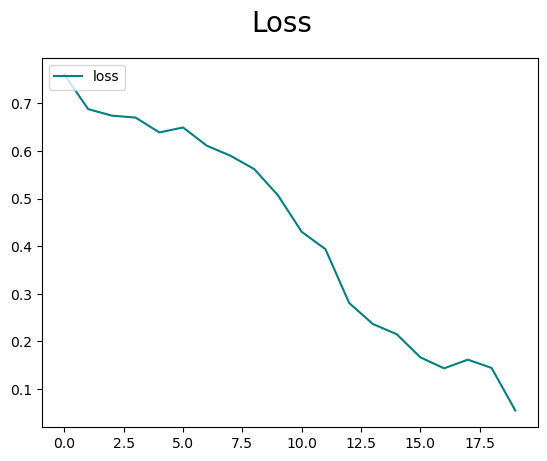

In [34]:
#Plotting Performance
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')

fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

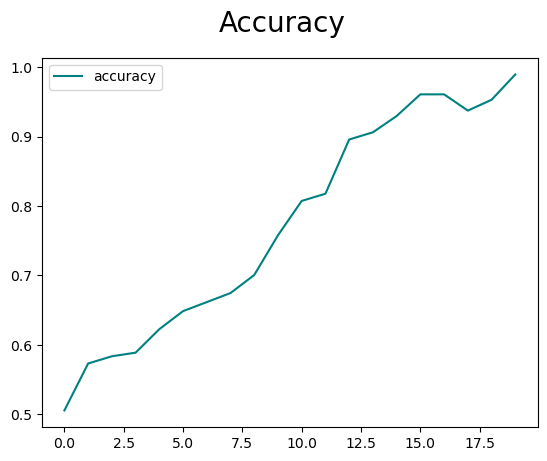

In [35]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')

fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

In [36]:
#Evaluating Performance
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [37]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [41]:
len(test)

1

In [42]:
for batch in test.as_numpy_iterator(): 
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

1/1 [==============================] - 0s 97ms/step


In [43]:
print(pre.result(), re.result(), acc.result())

tf.Tensor(0.969697, shape=(), dtype=float32) tf.Tensor(0.9411765, shape=(), dtype=float32) tf.Tensor(0.953125, shape=(), dtype=float32)


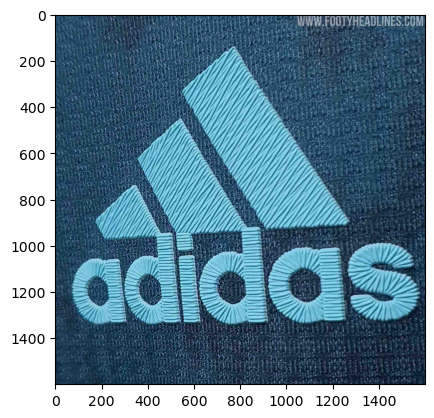

In [113]:
#Testing data
img = cv2.imread(r"C:\Users\aaron\Downloads\adidas-authentic-.jpg")
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

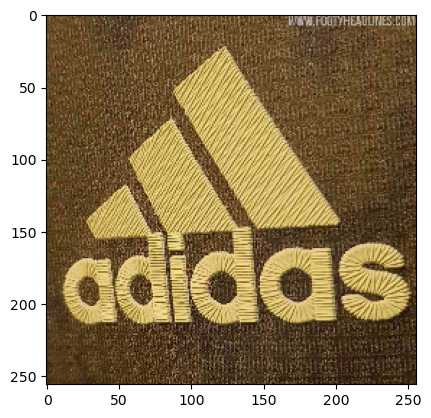

In [114]:
resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [115]:
yhat = model.predict(np.expand_dims(resize/255, 0))

1/1 [==============================] - 0s 40ms/step


In [116]:
yhat

array([[0.99894756]], dtype=float32)

In [117]:
if yhat > 0.5: 
    print(f'Predicted class is Real')
else:
    print(f'Predicted class is Fake')

Predicted class is Real
